In [1]:
pip install ipynb-py-convert

  Stored in directory: /Users/wakilahmad/Library/Caches/pip/wheels/80/dc/7c/a7279f7726d66951fe48d5afd45247bcf5bf92c98282e4e78e
Successfully built ipynb-py-convert
Note: you may need to restart the kernel to use updated packages.


In [1]:
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, auc
import numpy as np

#from rotation_forest import RotationForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, roc_auc_score
import pickle
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from rotation_forest import RotationForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
#from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor
from sklearn.metrics import recall_score
from sklearn.ensemble import VotingClassifier
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from collections import defaultdict


def conver_to_tensor(y_true, y_pred):
    return tf.convert_to_tensor(y_true, np.float32), tf.convert_to_tensor(y_pred, np.float32)


def correlation_coefficient_loss(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)


def matthews_correlation(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


def matthews_correlation_loss(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return (-(numerator / (denominator + K.epsilon()))+1)*100


def sensitivity(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


def specificity_loss(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_negatives = K.sum(K.clip((1-y_true) * (1-y_pred), 0, 1))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return - (true_negatives / (possible_negatives + K.epsilon()))


def recall_m(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_positives = K.sum((K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_positives = K.sum((K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 1 - 2 * ((precision * recall) / (precision + recall + K.epsilon()))


def robust_cross_val(x_train, y_train, x_test, y_test, folds):
    #skf = StratifiedKFold(n_splits=folds)
    #skf = KFold(n_splits=folds)
    skf = RepeatedKFold(n_splits=folds, n_repeats=2, random_state=42)

    model = LogisticRegression()
    #model = svm.SVC(kernel='linear', degree=3, gamma='scale')
    #model = svm.SVC(kernel='poly', degree=3, gamma='scale')
    #model = svm.SVC(kernel='rbf', degree=3, gamma='scale')
    #model = svm.SVC(kernel='sigmoid', degree=3, gamma='scale')
    #model = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=2, min_samples_leaf=1)
    #model = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, max_features='auto', min_impurity_split=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, random_state=0, warm_start=False)
    #model = GaussianNB()
    #model = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
    #model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=1, max_iter=300, learning_rate='constant', learning_rate_init=0.001)
    #model = MLPClassifier(random_state=1, max_iter=300)
    #model = AdaBoostClassifier(n_estimators=100, random_state=0)
    #model = RotationForestClassifier(n_estimators=100, random_state=47, verbose=4, n_jobs=-2)

    accuracy = []
    mcc = []
    precision = []
    roc_auc = []
    Sensitivity = []
    Specificity = []
    auc_score = []
    f1 = []
    score = []

    for x in range(10):
        for train_index, test_index in skf.split(x_train, y_train):
            X_train, X_test = x_train[train_index], x_train[test_index]
            Y_train, Y_test = y_train[train_index], y_train[test_index]

            model.fit(X_train, Y_train)
            y_predict = model.predict(X_test)
            score.append(model.score(X_test, Y_test))

            accuracy.append(accuracy_score(Y_test, y_predict))
            mcc.append(matthews_corrcoef(Y_test, y_predict))
            precision.append(precision_score(Y_test, y_predict))
            roc_auc.append(roc_auc_score(Y_test, y_predict))
            auc_score.append(auc(Y_test, y_predict))
            f1.append(f1_score(Y_test, y_predict))
            Sensitivity.append(sensitivity(Y_test, y_predict))
            Specificity.append(specificity(Y_test, y_predict))

    with open('./model/MLPrepeat.pkl', 'wb') as f:
        pickle.dump(model, f)

    res = "{} folds\n".format(folds)
    res += "******************** Cross Validation Score ********************\n"
    res += "Accuracy: {}\n".format(np.mean(accuracy))
    res += "MCC: {}\n".format(np.mean(mcc))
    res += "Precision: {}\n".format(np.mean(precision))
    res += "Roc AUC score: {}\n".format(np.mean(roc_auc))
    res += "F1 score: {}\n".format(np.mean(f1))
    res += "Sensitivity: {}\n".format(np.mean(Sensitivity))
    res += "Specifity: {}\n".format(np.mean(Specificity))

    y_test_predict = model.predict(x_test)
    res += "\n******************** Independent Test Score ********************\n"
    res += "Accuracy: {}\n".format(accuracy_score(y_test, y_test_predict))
    res += "MCC: {}\n".format(matthews_corrcoef(y_test, y_test_predict))
    res += "Precision: {}\n".format(precision_score(y_test, y_test_predict))
    res += "Roc AUC score: {}\n".format(roc_auc_score(y_test, y_test_predict))
    res += "F1 score: {}\n".format(f1_score(y_test, y_test_predict))
    res += "Sensitivity: {}\n".format(sensitivity(y_test, y_test_predict))
    res += "Specifity: {}\n\n\n".format(specificity(y_test, y_test_predict))

    with open('./new_results/MLPrepeat.txt', 'a') as f:
        f.write(res)

if __name__ == '__main__':
    # from google.colab import files
    # npzfile = files.upload(allow_pickle=True)
    npzfile = np.load('keat/knn_features_007_K-375.npz', allow_pickle=True)
    X_p = npzfile['arr_0']
    Y_p = npzfile['arr_1']
    X_n = npzfile['arr_2']
    Y_n = npzfile['arr_3']

    x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(X_p, Y_p, test_size=0.2, shuffle=True, random_state=42)
    x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(X_n, Y_n, test_size=0.2, shuffle=True, random_state=42)

    x_train = np.concatenate((x_train_p, x_train_n)).astype(np.float)
    x_test = np.concatenate((x_test_p, x_test_n)).astype(np.float)
    y_train = np.concatenate((y_train_p, y_train_n)).astype(np.float)
    y_test = np.concatenate((y_test_p, y_test_n)).astype(np.float)

    # x_train = np.concatenate(x_train_p).astype(np.float)
    # x_test = np.concatenate(x_test_p).astype(np.float)
    # y_train = np.concatenate(y_train_p).astype(np.float)
    # y_test = np.concatenate(y_test_p).astype(np.float)

    x_train = x_train.reshape(len(x_train), 456)
    x_test = x_test.reshape(len(x_test), 456)

    robust_cross_val(x_train, y_train, x_test, y_test, 10)


Using TensorFlow backend.
/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futu

In [2]:
print(robust_cross_val)

<function robust_cross_val at 0x1a35ba3158>


In [7]:
print(x_train.shape)
print(y_train.shape)

(1772, 456)
(1772,)


/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


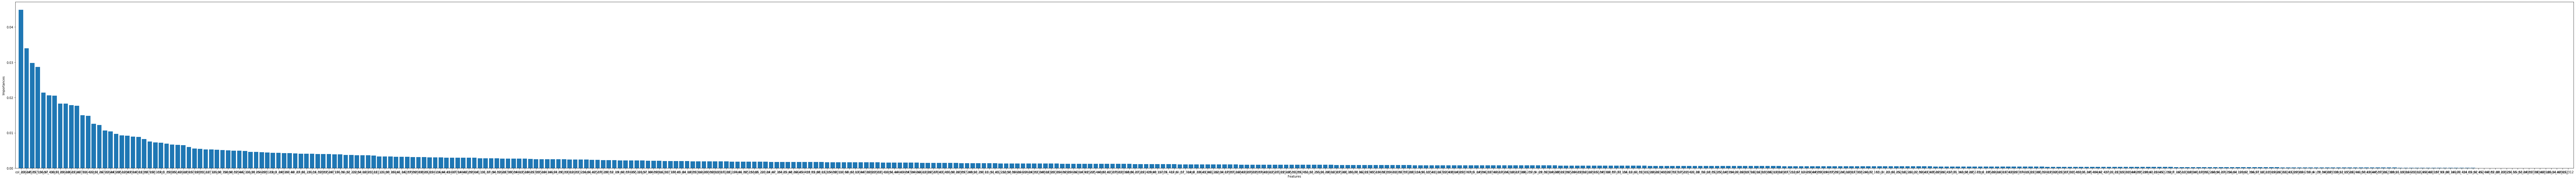

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(x_train,y_train)
feat_importances = model.feature_importances_
indices = np.argsort(feat_importances)[::-1]
plt.figure(figsize=(150, 10))
plt.bar(range(x_train.shape[1]), feat_importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), ["col_"+str(i) for i in indices])
plt.xlim([-1, x_train.shape[1]])
plt.xlabel('Features')
plt.ylabel('Importances')
plt.savefig("Feature Importances", bbox_inches='tight')
plt.show()

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef
from imblearn.metrics import sensitivity_score, specificity_score

curves = []

def plt_curve(lst, name):
  plt.figure(figsize=(20,10))
  
  for idx, itm in enumerate(lst):
    fpr, tpr = itm
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
    
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

def roc_plt(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
  curves.append([fpr, tpr])
  return 1

metrs = {
         'roc_plt': make_scorer(roc_plt, needs_proba=True), 
         'matthews_corrcoef': make_scorer(matthews_corrcoef), 
         'sensitivity_score': make_scorer(sensitivity_score), 
         'specificity_score': make_scorer(specificity_score)
        }

/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wakilahmad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

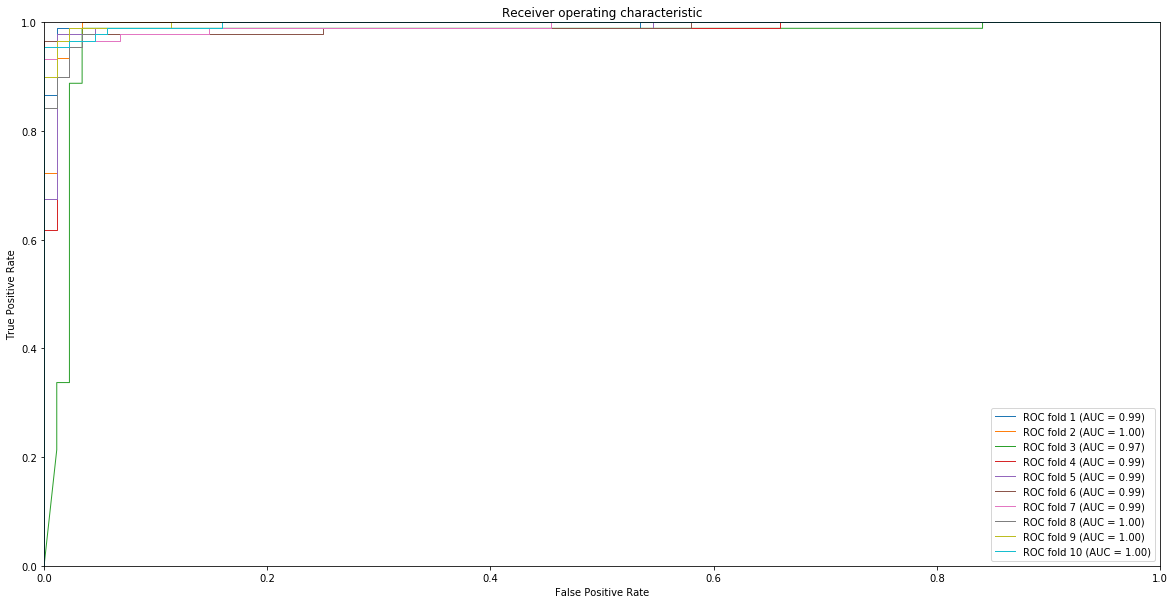

***CROSS VALIDATION***
SVM


{'fit_time': array([0.44210982, 0.43309188, 0.36033511, 0.45880413, 0.44718194,
        0.41711116, 0.46770191, 0.55769396, 0.44690204, 0.39137173]),
 'score_time': array([0.00690579, 0.00339913, 0.00338387, 0.00353289, 0.0036149 ,
        0.00334787, 0.0114131 , 0.00584316, 0.0036509 , 0.00354505]),
 'test_roc_plt': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'test_matthews_corrcoef': array([0.96635314, 0.95505051, 0.92096527, 0.96616014, 0.95480082,
        0.96666248, 0.93220123, 0.93220123, 0.96616014, 0.93244797]),
 'test_sensitivity_score': array([0.97777778, 0.97777778, 0.95505618, 0.98876404, 0.97752809,
        0.96629213, 0.96629213, 0.96629213, 0.98876404, 0.95505618]),
 'test_specificity_score': array([0.98863636, 0.97727273, 0.96590909, 0.97727273, 0.97727273,
        1.        , 0.96590909, 0.96590909, 0.97727273, 0.97727273])}

In [11]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

curves = []

scores = cross_validate(classifier, 
                        x_train, 
                        y_train, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=False)

plt_curve(curves, "SVM CV")
print("***CROSS VALIDATION***")
print("SVM")
scores
#scores['roc']=curves